# Lab 8: Working with netCDF Files

In this lab, we will work with geospatial data stored in netCDF files using the **xarray** package.

In the following sections, you will learn how to open netCDF files with xarray, manipulate 1D time series and 2D spatial data, and visualize the results.

## Introduction to **netCDF (Network Common Data Form)** Files



![Multidimensional data structure showing dimensions (time, latitude, longitude), coordinates, and data variables in a netCDF file](https://climatedata.ca/site/assets/uploads/2024/10/netcdf3.png)

A netCDF **Dataset** contains multiple **DataArrays**, which hold the actual data, such as **variables** like **temperature** and **precipitation**. These variables are structured along **coordinates** - in this case, **latitude** and **longitude** - and mapped across different dimensions (e.g., x, y, and t for time). The **Dimensions** represent the axes of the data (spatial and temporal), and **Indexes** provide reference points within these dimensions. This multidimensional capability allows netCDF to efficiently store data such as climate model outputs, satellite observations, or reanalysis data (*[Source](https://climatedata.ca/ask-a-climate-expert-how-do-i-use-netcdf-files/)*).

### Key Differences from Excel:
- **Dimensions:** netCDF supports multiple dimensions (e.g., time, space), not just 2D tables.
- **Metadata:** Each variable in a netCDF file includes metadata (e.g., units, descriptions) which makes it self-describing.
- **Scalability:** Designed for very large datasets that may not fit into memory.

### GRIB
One of the common alternatives to netCDF is **GRIB (GRIdded Binary)**. GRIB files are widely used in meteorology and are optimized for storage and transmission of weather forecast data; typically more compressed. We will not be using GRIB in this lab.

## ERA5-Land 

**Fifth generation ECMWF atmospheric reanalysis of the global climate (ERA5-Land)** is a climate reanalysis dataset that provides high-resolution land-surface variables. It is produced by the European Centre for Medium-Range Weather Forecasts (ECMWF) and is available through the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/). We will be using the dataset for all lab examples. 

[ERA5-Land monthly averaged data (Variable descriptions found in link)](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview):

| Dataset | Spatial Resolution    | Temporal Resolution       | Time Period|
|---------|-----------------------|---------------------------|--|
| ERA5-Land    | 0.1° x 0.1°   | Monthly                   |1950 CE - present|

## Introduction to xarray

[xarray](http://xarray.pydata.org/en/stable/) is a Python library that makes working with multidimensional arrays (e.g., netCDF data) simple and efficient. It builds on the power of NumPy, while also handling labels (for dimensions, coordinates, and attributes) that allow for self-describing datasets.

In [1]:
# Preamble
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline

We will begin the lab by looking at some commonly used functions and operations for geospatial analysis with xarray:

### Opening and Inspecting Datasets

- `xr.open_dataset()`: Opens a netCDF file and returns an xarray Dataset.
- `xr.open_mfdataset()`: Opens multiple netCDF files as one Dataset, useful for handling time series split across files.

Simply type the dataset variable to view its contents:

In [2]:
ds = xr.open_dataset("data/era5_bc.nc")
ds

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 902, latitude: 21, longitude: 51)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2025-02-01
  * latitude    (latitude) float64 168B 50.0 49.9 49.8 49.7 ... 48.2 48.1 48.0
  * longitude   (longitude) float64 408B -125.0 -124.9 -124.8 ... -120.1 -120.0
    expver      (valid_time) <U4 14kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 4MB ...
    tp          (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-10T23:44 GRIB to CDM+CF via cfgrib-0.9.1...

### Selecting and Indexing Data

- `Dataset.sel()`: Selects data by labels (e.g., specific coordinates).
    - The labels used for selection are not universal are found in your specific dataset, above listed as `Coordinates`
- `Dataset.isel()`: Selects data by integer location (like positional indexing).
- `Dataset.where()`: Filters data based on a condition.
- `slice()`: Used within `sel()` or `isel()` to select data along a dimension over a specified range. For example, `ds.sel(time=slice('1950-01-01', '1950-12-01'))` selects all data between the specified start and end dates. This is useful for temporal or spatial subsetting when working with `xarray` objects.

*Note: If you want to time slice using a specific date like `'1950-01-01'`, you need to use `.sel()` instead of `.isel()` because `.isel()` works with integer based index positions, not labels.*

In [3]:
# Selecting data for a specific latitude and longitude
subset = ds.sel(latitude=50.0, longitude=-120.0)

# Selecting data for a specific time
time_slice = ds.sel(valid_time='1950-01-01') # 'valid_time' is the time dimension for this dataset

# Selecting a range of dates using slice()
time_slice_1950 = ds.sel(valid_time=slice('1950-01-01', '1950-12-01')) 

# Selecting by index position
time_slice_index = ds.isel(valid_time=0) # This selects the first time step (1950-01-01)

# Applying a condition
filtered = ds.where(ds.t2m > 273.15, drop=True) # This dataset uses Kelvin, so 273.15 K is 0 degrees Celsius

If all we are interested is variable values at specific dimensions, we can access those using a combination of the above functions. 

We append `.values` to the desired variable to get its printed value:

In [31]:
# 2 m air temperature at latitude 50.0, longitude -120.0 for January 1950
print(ds.sel(latitude=50.0, longitude=-120.0, valid_time='1950-01-01').t2m.values) 

## 2 m air temperature at latitude 50.0, longitude -120.0 for each month of 1950
# Add .sel(valid_time=slice(time_start, time_end)) to select a range of dates
print(ds.sel(latitude=50.0, longitude=-120.0).sel(valid_time=slice('1950-01-01', '1950-12-01')).t2m.values) 

250.75954
[250.75954 265.8557  267.87134 271.42822 274.90283 282.2456  286.27344
 286.38696 283.97168 274.08447 267.95752 267.6714 ]


### `.dt` Accessor

- The `.dt` accessor is a datetime properties interface for xarray (similar to pandas). It allows you to extract datetime components (like `year`, `month`, `day`, `season`) from a `DataArray` or `Dataset` containing datetime values.
- Experiment with how xarray reads different datetime components from the DataArray below:

In [35]:
# ds.valid_time.dt.month
# ds.valid_time.dt.year
# ds.valid_time.dt.day
# ds.valid_time.dt.season

### Aggregating Data

- `Dataset.mean()`, `Dataset.sum()`, `Dataset.median()`: Compute statistics over specified dimensions.
- `Dataset.resample(dim='rule')`: Resample time series data (e.g., daily to monthly).
    - `dim`: The dimension along which to resample.
    - `rule`: Frequency fro resampling. E.g.:
        - `D`: Daily
        - `ME`: Monthly
        - `YE`: Annually
        - [Full list](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
- `Dataset.groupby('array')`: Group data by categories (e.g., month or season).

In [ ]:
# Calculate the mean temperature over time
mean_temp = ds.t2m.mean(dim="valid_time")

# Yearly average temperature
yearly_avg = ds.resample(valid_time="YE").mean()

# Group by season
seasonal_avg = ds.groupby("valid_time.season").mean() # This will group the ENTIRE ds by season and calculate the mean for each season (DJF, MAM, JJA, SON)

### Mathematical Operations

- `+`, `-`, `*`, `/`: Element-wise operations.
- `Dataset.cumsum()`: Cumulative sum along a dimension.
- `Dataset.rolling()`: Rolling window/Moving average operations. Useful for analyzing temperature trends while minimizing short-term fluctuations.

In [7]:
# Calculate temperature anomaly
anomaly = ds.t2m - ds.t2m.mean(dim="valid_time")

# Rolling mean (e.g., 10-month moving average)
rolling_mean = ds.t2m.rolling(valid_time=10, center=True).mean()

### Combining and Merging Datasets

- `xr.concat()`: Concatenates (links) datasets along a specified dimension.
- `xr.merge()`: Merges datasets with different variables.

### Visualization

xarray integrates seamlessly with Matplotlib:

- `Dataset.plot()`: Plots data directly, either as line plots or spatial maps.
- `Dataset.plot.contour()`: Contour plots for 2D data.
- `Dataset.plot.imshow()`: Visualizes images.

### Faceting
Faceting refers to splitting an array along one or two dimensions and plotting each group separately. This approach is especially helpful when dealing with datasets with three or more dimensions. Xarray’s basic plotting is useful for visualizing two-dimensional arrays, but when dealing with higher-dimensional data, faceting becomes essential.

The general approach to plotting here is called “small multiples”, where the same type of plot is repeated for different subsets of the data. When these subsets are conditioned on one or more variables, it's often called a “trellis plot”.

- `col`: Specifies the dimension along which the dataset will be split to create separate plots. For example, if you have a time series dataset and want to create separate maps for each month, you would set `col='valid_time'`.
- `col_wrap`: Controls the number of plots displayed per row before wrapping to the next row. This helps avoid overly long rows of plots and provides better visual organization.

Consider the ERA5 dataset where we want to visualize total precipitation (`tp`) for each month of a specific year. Without using `col_wrap`, plots would be arranged in a single long row. Using `col_wrap=4`, the plots are displayed in a grid with four plots per row.

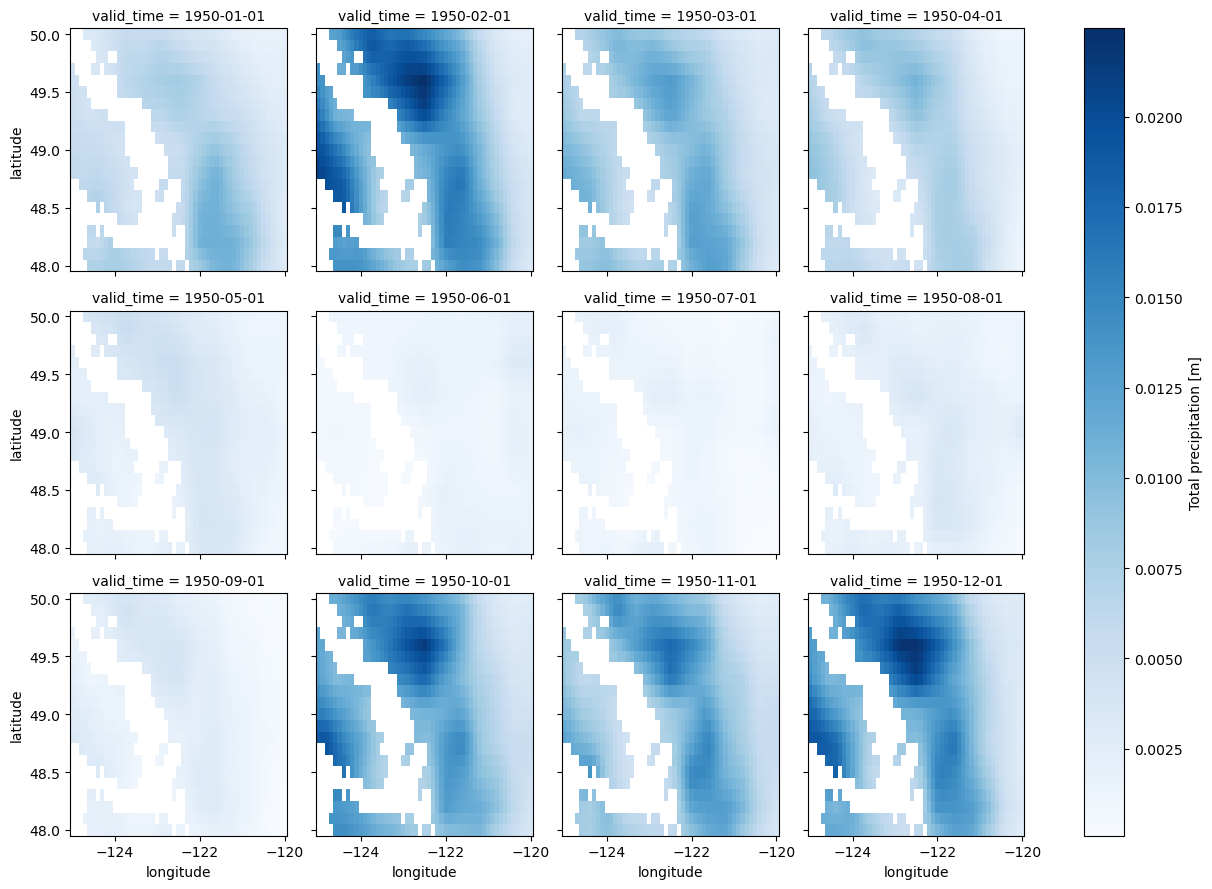

In [23]:
ds = xr.open_dataset("data/era5_bc.nc")

# Selecting 'tp' (total precipitation) and a range of dates using slice()
facet = ds.tp.sel(valid_time=slice('1950-01-01', '1950-12-01'))  

# Plotting with faceting
facet.plot(x='longitude', y='latitude', col='valid_time', col_wrap=4, cmap='Blues')

## Bringing it all together

### Slicing by latitude/longitude

In [73]:
ds = xr.open_dataset("data/era5_yt.nc")

# Convert t2m from Kelvin to Celsius
ds['t2m'] = ds['t2m'] - 273.15

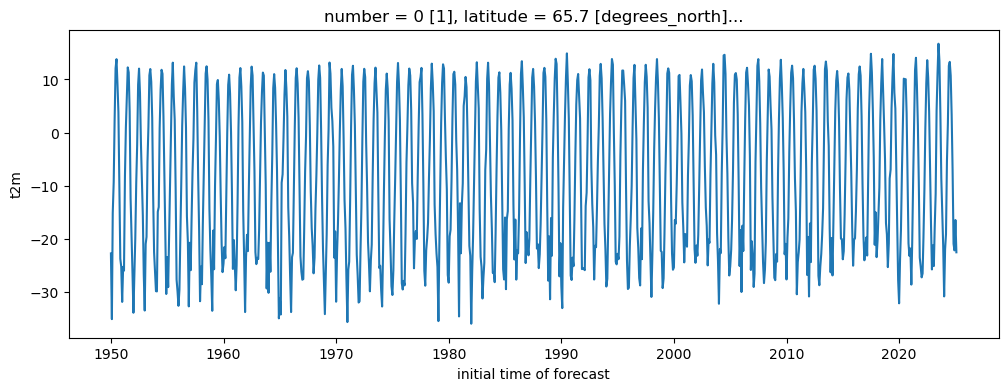

In [74]:
ds_1d = ds.sel(latitude=65.7, longitude=-138.6, method='nearest')
ds_1d.t2m.plot.line(figsize=(12,4))
# Note how Python reads and populates axis labels with the attributes of the DataArray

We can further slice by time to see a range of time at the same latitude by adding an additional `.sel()` function

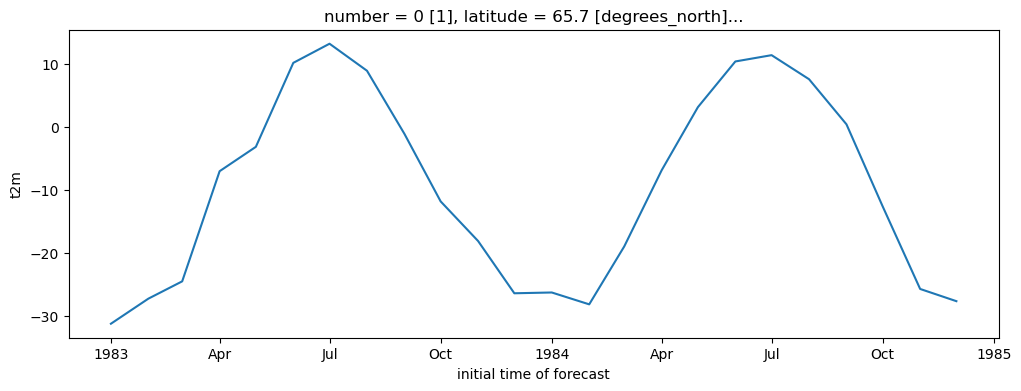

In [75]:
ds_1d = ds.sel(latitude=65.7, longitude=-138.6, method='nearest').sel(valid_time=slice('1983-01-01', '1984-12-01'))
ds_1d.t2m.plot.line(figsize=(12,4))

Add a multiple lines of latitude by defining the dimension as a list in brackets:

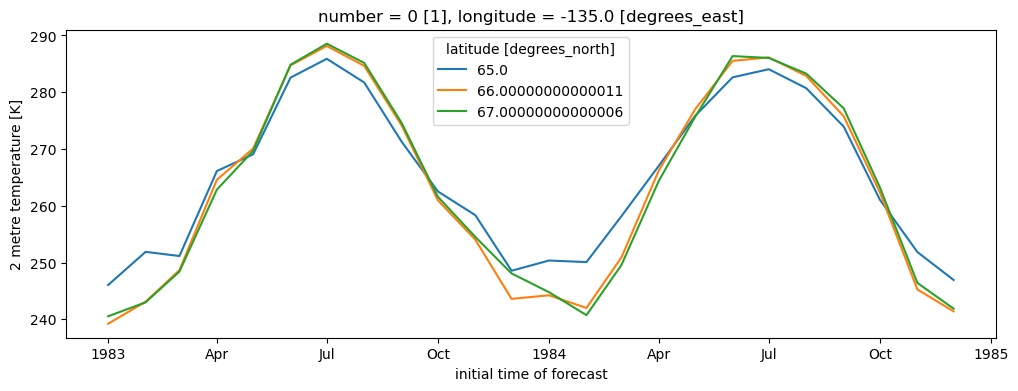

In [89]:
ds = xr.open_dataset("data/era5_yt.nc")

ds_1d = ds.sel(latitude=[65, 66, 67], longitude=-135, method='nearest').sel(valid_time=slice('1983-01-01', '1984-12-01'))
ds_1d.t2m.plot.line(figsize=(12,4), x='valid_time') # Legend is odd because of the way the data is structured

When plotting multiple lines showing variation (latitude) along a dimension (time), it is required to explicitly specify either:

1. `x`: the dimension to be used for the x-axis, or

2. `hue`: the dimension you want to represent by multiple lines.

Thus, we could have made the previous plot by specifying `hue='latitude'` instead of `x='valid_time'`. If required, the automatic legend can be turned off using `add_legend=False`.

### Seasonal analysis

Let's look at a way we can calculate seasonal averages over each year for the entire dataset using some of the functions we learned:

#### 1-Dimensional Data Analysis

In [109]:
ds = xr.open_dataset("data/era5_bc.nc")

# Convert t2m from Kelvin to Celsius
ds['t2m'] = ds['t2m'] - 273.15

# Assign the season to each time point
ds['season'] = ds.valid_time.dt.season

# Compute the adjusted season year (shift December to the next year)
# xr.where() = When True, return values from x, otherwise returns values from y.
ds['season_year'] = xr.where(
    ds.valid_time.dt.month == 12, # When true
    ds.valid_time.dt.year + 1, # Return this
    ds.valid_time.dt.year # Otherwise, return this
)

# Group by both season and season_year, then compute the mean
seasonal_avg = ds.groupby(['season', 'season_year']).mean()
seasonal_avg

<xarray.Dataset> Size: 3MB
Dimensions:      (season: 4, season_year: 76, latitude: 21, longitude: 51)
Coordinates:
  * season       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * season_year  (season_year) int64 608B 1950 1951 1952 1953 ... 2023 2024 2025
    number       int64 8B 0
  * latitude     (latitude) float64 168B 50.0 49.9 49.8 49.7 ... 48.2 48.1 48.0
  * longitude    (longitude) float64 408B -125.0 -124.9 -124.8 ... -120.1 -120.0
Data variables:
    t2m          (latitude, longitude, season, season_year) float32 1MB nan ....
    tp           (latitude, longitude, season, season_year) float32 1MB nan ....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-10T23:44 GRIB to CDM+CF via cfgrib-0.9.1...

**Code breakdown:**

- `ds['season'] = ds.valid_time.dt.season`
    - For each timestamp in `valid_time`, `.dt.season` returns the meteorological season:
        - `DJF` (December, January, February)
        - `MAM` (March, April, May)
        - `JJA` (June, July, August)
        - `SON` (September, October, November)
- We then create a new variable `season_year` to handle seasons that cross calendar years (e.g., DJF includes December 2020, January 2021, February 2021).
    - For December (month 12), the year is incremented by 1 (so December 2020 becomes part of "season year" 2021).
    - For other months, the year remains unchanged.
- `seasonal_avg = ds.groupby(['season', 'season_year']).mean()`
    - Groups your data by both `season` (e.g., DJF) and `season_year` (the adjusted year), then computes the mean for each group.

Now we can loop over each season and visualize as a line plot!

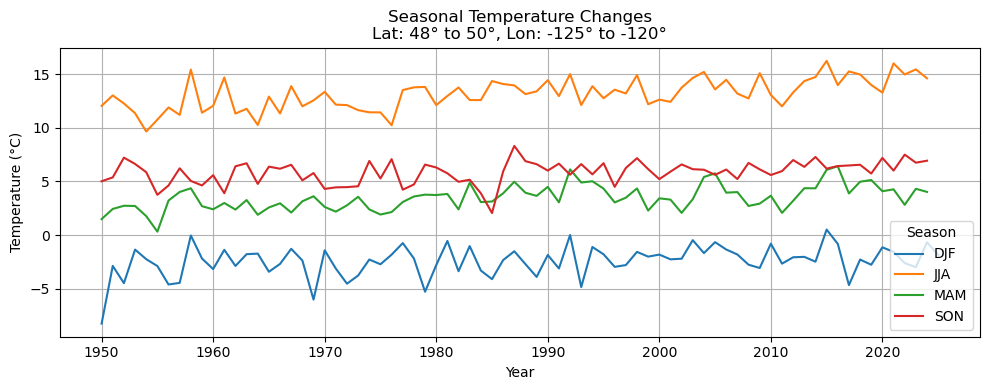

In [110]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Loop over each seasons' values and plot its data
for season in seasonal_avg['season'].values: # DJF, MAM, JJA, SON
    # Extract the data for the current season
    season_data = seasonal_avg.sel(season=season).mean(dim=('latitude', 'longitude'))  # Average seasonal means over all lat/lon coords
    # Plot the data
    ax.plot(season_data['season_year'], season_data['t2m'], label=season)

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Seasonal Temperature Changes\nLat: 48° to 50°, Lon: -125° to -120°')
ax.legend(title='Season')
ax.grid(True)
plt.tight_layout()

#### 2-Dimensional Data Analysis
Let's plot the same as above, but as a 2D map for the year of 2020:

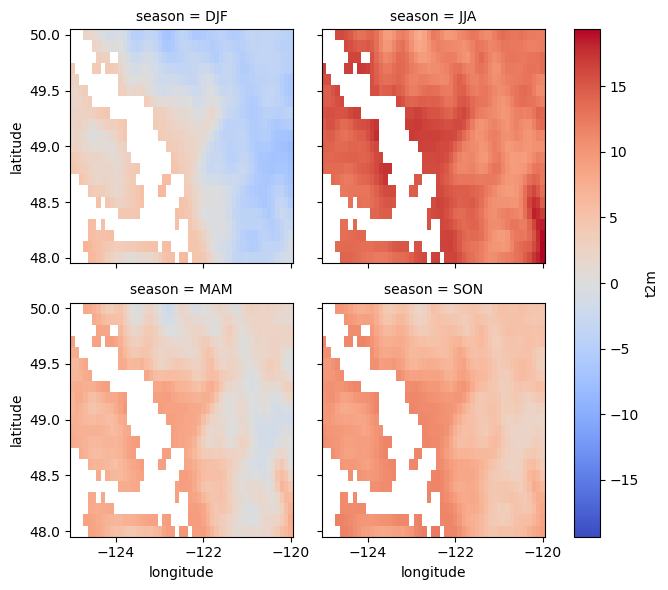

In [119]:
# Select only the year 2020
seasonal_2020 = seasonal_avg.sel(season_year=2020).t2m

# Plotting with faceting
seasonal_2020.plot(x='longitude', y='latitude', col='season', col_wrap=2, cmap='coolwarm')

### Comparative analysis
In this section, we will work with ERA5-Land temperature data to perform a comparative analysis between two regions:
- **Southern British Columbia (BC):** Latitudes between 48°N and 50°N and longitudes between -125°W and -120°W.
- **Northern Yukon:** Latitudes between 65°N and 68°N and longitudes between -140°W and -135°W.

#### 1-Dimensional Data Analysis

In [ ]:
# Read netCDF files for BC and Yukon
bc = xr.open_dataset('data/era5_bc.nc')
yt = xr.open_dataset('data/era5_yt.nc')

We define a baseline period to compute monthly climatology for. In this case, **monthly climatology** is the average temperature for each month defined in our baseline period (e.g., average of all January temperatures from 1950 - 1980). We then subtract the monthly climatology from each month in the dataset to obtain anomalies.

In [ ]:
# Define baseline period
baseline_start = '1950-01-01'
baseline_end = '1980-01-01'

# Function to calculate anomalies
def era5_anomalies(ds):
    # Select baseline period and compute monthly average
    clim = ds.t2m.sel(valid_time=slice(baseline_start, baseline_end))
    monthly_clim = clim.groupby('valid_time.month').mean(dim='valid_time')
    
    # Calculate anomalies by subtracting monthly climatology
    return ds.t2m.groupby('valid_time.month') - monthly_clim

In [ ]:
# Calculate anomalies for both regions
bc_anom = era5_anomalies(bc)
yt_anom = era5_anomalies(yt)

# Compute spatial averages by taking the mean over latitude and longitude dimensions
bc_avg_anom = bc_anom.mean(dim=['latitude', 'longitude'])
yt_avg_anom = yt_anom.mean(dim=['latitude', 'longitude'])

Before we plot, we can obtain averages for 1950 and 2024 of the anomaly values we just calculated for a simple assessment:

In [155]:
print('BC average anomalies')
print(f'1950:')
print(bc_avg_anom.sel(valid_time=slice('1950-01-01', '1950-12-01')).mean().values)
print('2024:')
print(bc_avg_anom.sel(valid_time=slice('2024-01-01', '2024-12-01')).mean().values)

print('\nYT average anomalies')
print(f'1950:')
print(yt_avg_anom.sel(valid_time=slice('1950-01-01', '1950-12-01')).mean().values)
print('2024:')
print(yt_avg_anom.sel(valid_time=slice('2024-01-01', '2024-12-01')).mean().values)

BC average anomalies
1950:
-1.1279706
2024:
1.8010231

YT average anomalies
1950:
1.0575047
2024:
2.2648175


Seems that Yukon has higher average anomalies (*Arctic Amplification???*), let's see what a plot can illustrate:

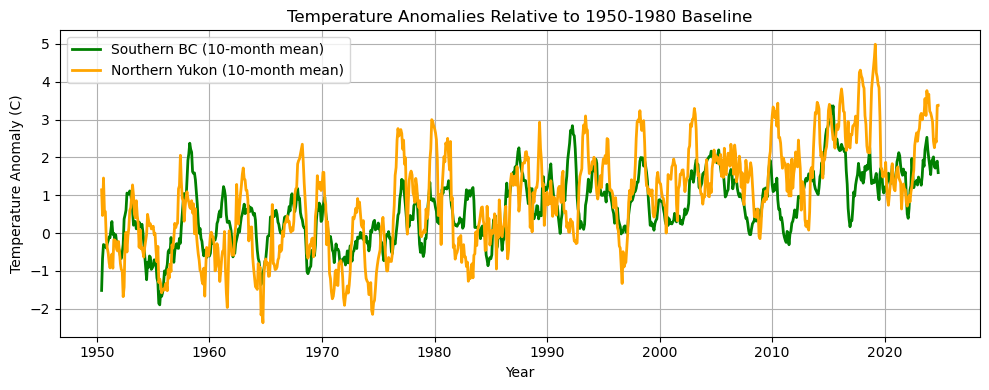

In [159]:
# Create plot 
plt.figure(figsize=(10, 4))

# Add 12-month rolling mean for trend clarity
bc_avg_anom.rolling(valid_time=10, center=True).mean().plot(
    color='green', linewidth=2, label='Southern BC (10-month mean)')
yt_avg_anom.rolling(valid_time=10, center=True).mean().plot(
    color='orange', linewidth=2, label='Northern Yukon (10-month mean)')

plt.title('Temperature Anomalies Relative to 1950-1980 Baseline')
plt.ylabel('Temperature Anomaly (C)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Exercise:** Remove the BC rolling mean and add additional 20 and 50 month rolling means for the Yukon. Plot using different colours and update the labels accordingly.

#### 2-Dimensional Data Analysis

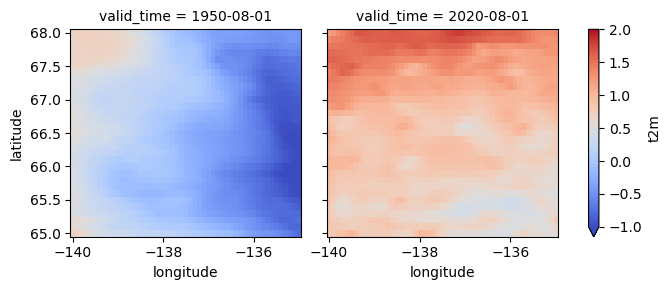

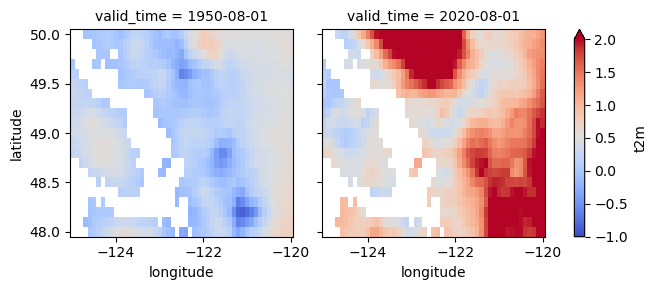

In [121]:
# Define the colorbar limits to ensure consistency between plots
vmin, vmax = -1, 2

# Define dynamic times and labels
time1, time2 = '1950-08-01', '2020-08-01'

# Select years of interest for BC and YT
yt_sel = yt_anom.sel(valid_time=[time1, time2])
bc_sel = bc_anom.sel(valid_time=[time1, time2])

# Plotting with faceting
yt_sel.plot(x='longitude', y='latitude', col='valid_time', col_wrap=2, cmap='coolwarm', vmin=vmin, vmax=vmax)
bc_sel.plot(x='longitude', y='latitude', col='valid_time', col_wrap=2, cmap='coolwarm', vmin=vmin, vmax=vmax)

# End of Lab 8!

Bonus: The above plot is great for quick plotting, but you may find yourself needing to add overlays and access to more customization options. Below is an example that plots each individually, so is a bit clunkier, but allows making a cleaner, perhaps publication worthy, plot.

*Note: when overlaying a shapefile with xarray, the projection defaults to PlateCarree.*

Text(0.5, 0.98, 'Temperature anomalies (°C) relative to 1950 - 1980 baseline')

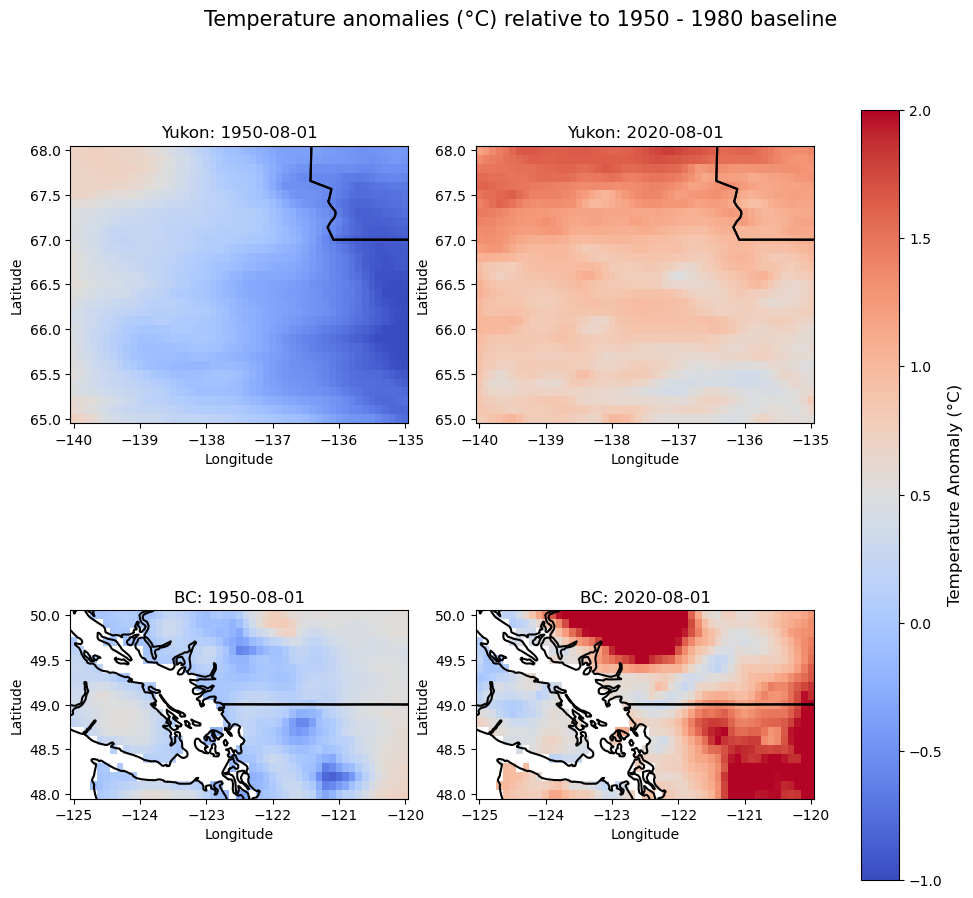

In [ ]:
# Load in shapefile containing North America boundaries
na_bounds = gpd.read_file("data/ns372xw1938.shp")

# Define common plotting parameters
vmin, vmax = -1, 2

# Define dynamic times and labels
time1 = '1950-08-01'
time2 = '2020-08-01'

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)

# Plot YT (1950-08)
yt_plot = yt_anom.sel(valid_time=time1).plot(ax=axes[0, 0], cmap='coolwarm', vmin=vmin, vmax=vmax, add_colorbar=False) # Save plot for colorbar
na_bounds.boundary.plot(ax=axes[0, 0], edgecolor='black') # Add NA boundaries
axes[0, 0].set_title(f'Yukon: {time1}') # Add dynamic title

# Plot YT (2020-08)
yt_anom.sel(valid_time=time2).plot(ax=axes[0, 1], cmap='coolwarm', vmin=vmin, vmax=vmax, add_colorbar=False)
na_bounds.boundary.plot(ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title(f'Yukon: {time2}')

# Plot BC (1950-08)
bc_anom.sel(valid_time=time1).plot(ax=axes[1, 0], cmap='coolwarm', vmin=vmin, vmax=vmax, add_colorbar=False)
na_bounds.boundary.plot(ax=axes[1, 0], edgecolor='black')
axes[1, 0].set_title(f'BC: {time1}')

# Plot BC (2020-08)
bc_anom.sel(valid_time=time2).plot(ax=axes[1, 1], cmap='coolwarm', vmin=vmin, vmax=vmax, add_colorbar=False)
na_bounds.boundary.plot(ax=axes[1, 1], edgecolor='black')
axes[1, 1].set_title(f'BC: {time2}')

# Add common x and y labels using for loop
for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    axes[i, j].set_xlabel('Longitude')
    axes[i, j].set_ylabel('Latitude')

# Add a common colorbar based off any defined plot (they are all normalized so it doesn't matter which one, but the only one that is defined is yt_plot)
cbar = fig.colorbar(yt_plot, ax=axes)
cbar.set_label('Temperature Anomaly (°C)', fontsize=12)

# Add a common title
plt.suptitle('Temperature anomalies (°C) relative to 1950 - 1980 baseline', fontsize=15)